<a href="https://colab.research.google.com/github/naveens01/-diseases-analyser/blob/main/Palm_Model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive
%cd Ancient-Tail-Script-Recognition-master

Mounted at /content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
from google.colab.patches import cv2_imshow
import imutils
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt
from pathlib import Path
import os, pickle
import numpy
import random
from google.colab.patches import cv2_imshow

In [ ]:
import PIL
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

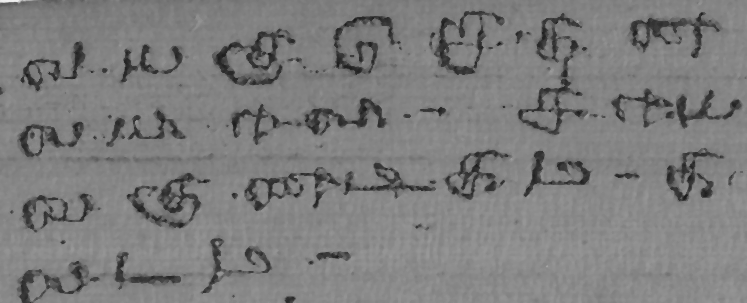

In [ ]:
image = cv2.imread("/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/palm word.png")
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
filter1 = cv2.medianBlur(gray,3)
cv2_imshow(filter1)

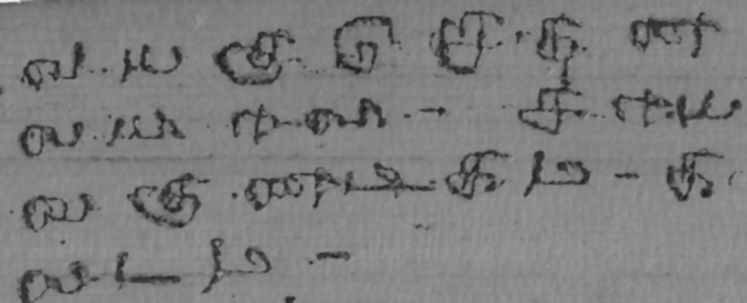

In [ ]:
filter2 = cv2.GaussianBlur(filter1,(3,3),0)
cv2_imshow(filter2)

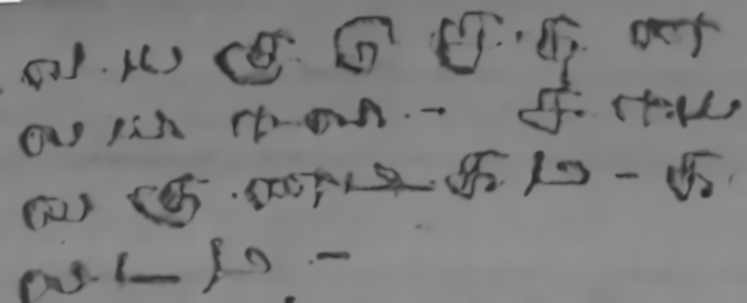

In [ ]:
dst = cv2.fastNlMeansDenoising(filter2,None,17,7,17)
cv2_imshow(dst)

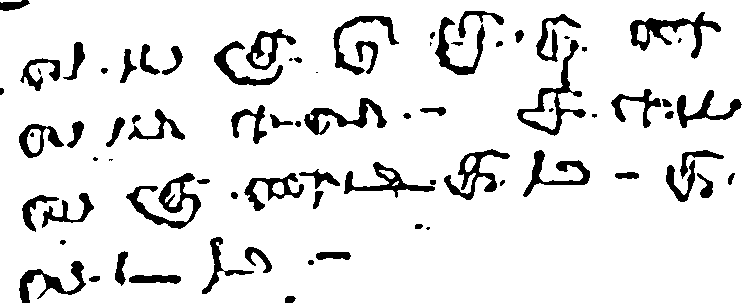

In [ ]:
th1 = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,5)
cv2_imshow(th1)

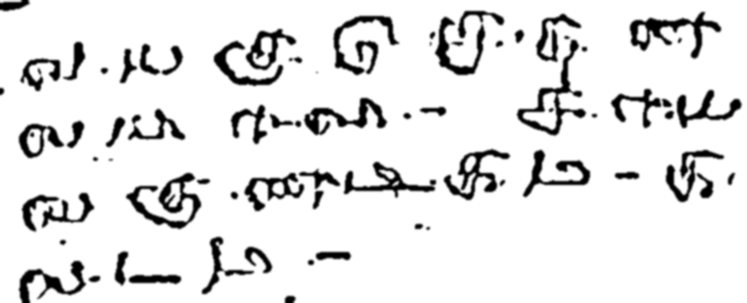

In [ ]:
#image = cv2.imread("ImagePreProcessingFinal2.jpg")
image=th1
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(th1, (5,5), 0)
cv2_imshow(gray)

In [ ]:
ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
print(ret)
print(thresh1)

127.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


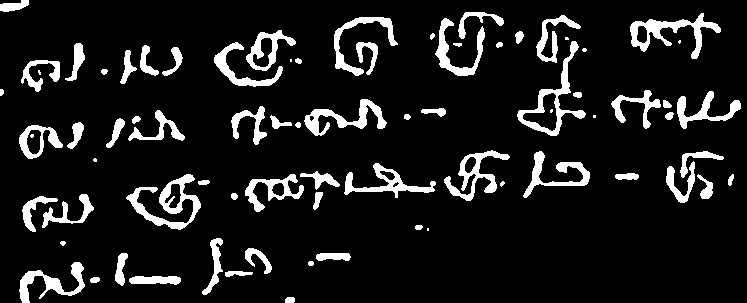

In [ ]:
open = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, (5,5))
cv2_imshow(open)

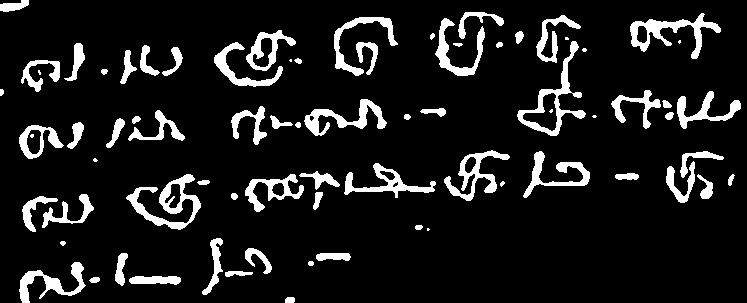

In [ ]:
close = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, (5,5))
cv2_imshow(close)

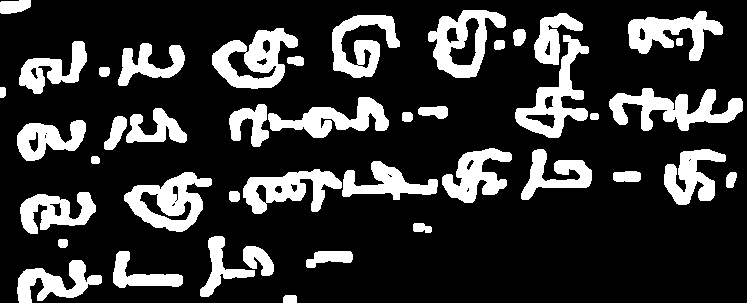

In [ ]:
dilate = cv2.dilate(close, None, iterations=2)
cv2_imshow(dilate)

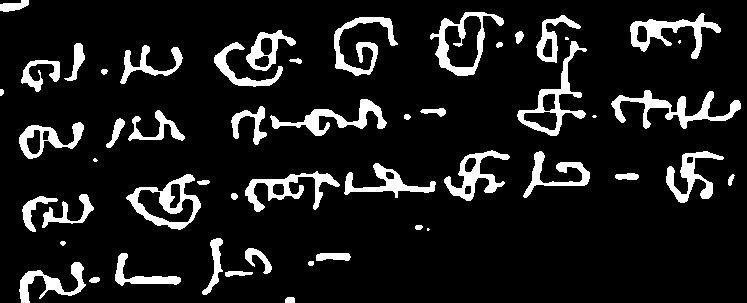

In [ ]:
erode = cv2.erode(dilate, None, iterations=2)
cv2_imshow(erode)
dilate1=erode

In [ ]:
cnts = cv2.findContours(dilate1.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[0]
print(cnts)

In [ ]:
cv2.contourArea(cnts[0])

42.5

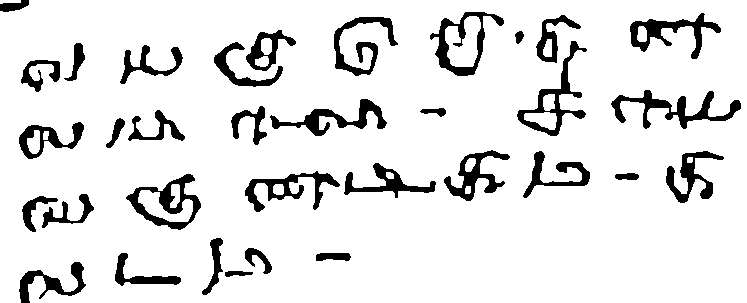

In [ ]:
for cnt in cnts:
  if(cv2.contourArea(cnt) < 50):
    cv2.fillPoly(dilate1, pts=[cnt], color=(0, 0, 0))
dilate1=~dilate1
cv2_imshow(dilate1)

In [ ]:
cnts = cv2.findContours(dilate1.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[0]
print(cnts)

In [ ]:
cv2.contourArea(cnts[0])

In [ ]:
sorted_ctrs = sorted(cnts, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * image.shape[1] )
sorted_ctrs

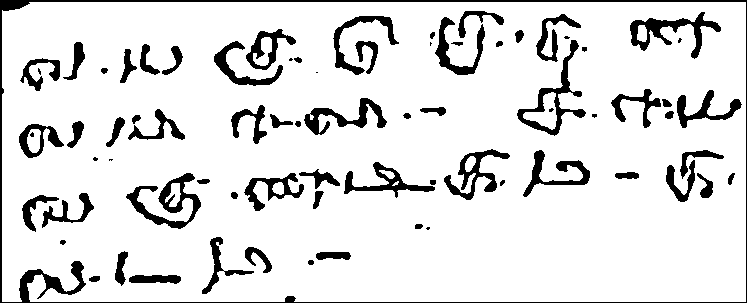

In [ ]:
cv2_imshow(orig)

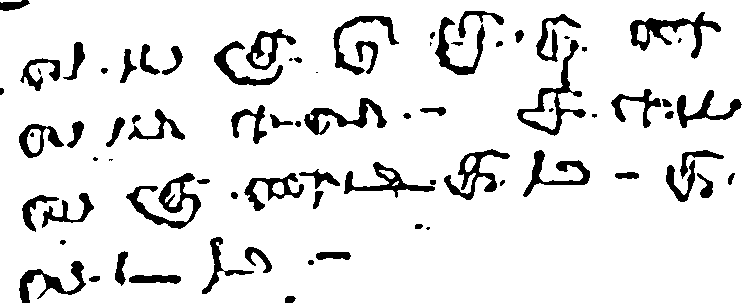

In [ ]:
import os
orig = image.copy()
i = 0
for cnt in sorted_ctrs:
    # Check the area of contour, if it is very small ignore it
    if(cv2.contourArea(cnt) < 50):
      cv2.fillPoly(orig, pts=[cnt], color=(0, 0, 0))
      continue

    # Filtered countours are detected
    x,y,w,h = cv2.boundingRect(cnt)

    # Taking ROI of the cotour
    image2=image
    roi = image[y:y+h, x:x+w]
    cv2_imshow(roi)
    path = '/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Seg_2'
    cv2.imwrite(os.path.join(path, str(i)+".jpg"), roi)

    # Mark them on the image if you want
    cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)

    # Save your contours or characters
    cv2.imwrite("Images/roi" + str(i) + ".png", roi)

    i = i + 1

In [ ]:
cv2.imwrite("box.jpg",orig)

True

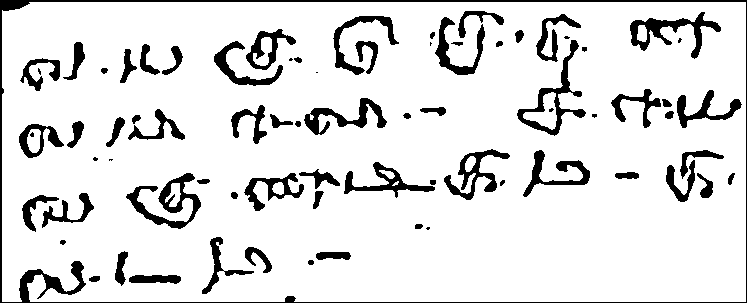

In [ ]:
cv2_imshow(orig)

In [ ]:
file_list = []
class_list = []
IMG_SIZE = 50 # The size of images the network will work on

In [ ]:
#All the categories that should be detect in neural network

CATEGORIES = []
ignore_files = ['1 - Multipart','2 - Unknown','3 - Images'] #This files/folder should not include in neural network
DATADIR = r'/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Seg_Images'
for directoryfile in os.listdir(DATADIR):
    if(directoryfile in ignore_files):
        continue
    CATEGORIES.append(directoryfile) #Append all the character's name as label in 'CATEGORIES'
print(len(CATEGORIES))

58


In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category) # Charcater's name label as class number
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Converting image into grayscale
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #Resizing all images into same size (50,50)
                #new_array = cv2.resize(img_array)
                training_data.append([new_array, class_num]) # append all images with their respective class name
            except Exception as e:
                print(path)
                pass

create_training_data()

/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Seg_Images/ச
/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Seg_Images/டு


In [ ]:
training_data

In [ ]:
#Storing features in X and labels in Y using numpy

random.shuffle(training_data)
X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
#Saving features and label in pickle files

pickle_out = open("/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Pickle/X2.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Pickle/y2.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
#Loading pickle files
file_path_X = open(os.path.join(r"/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Pickle/X2.pickle"), 'rb')
file_path_Y = open(os.path.join(r"/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/Pickle/y2.pickle"), 'rb')
X = pickle.load(file_path_X)
y = pickle.load(file_path_Y)

In [ ]:
number_of_classes = max(y) + 1 #Number of classes

In [ ]:
X = X/255.0 #Normalising the images

In [ ]:
print(X.shape)

(951, 50, 50, 1)


In [ ]:
# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(64, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten()) #Transforms all information from previous convolutions into inputs for neurons
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(128))
model.add(Activation("relu"))

# The output layer for given number of classes
model.add(Dense(number_of_classes))
model.add(Activation("softmax"))

# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
y=numpy.asarray(y)

In [ ]:
# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
history = model.fit(X, y, batch_size=32, epochs=40, validation_split=0.1)

Epoch 1/40
27/27 [==============================] - 5s 150ms/step - loss: 3.6043 - accuracy: 0.0865 - val_loss: 3.2402 - val_accuracy: 0.1250
Epoch 2/40
27/27 [==============================] - 4s 141ms/step - loss: 3.3434 - accuracy: 0.1076 - val_loss: 3.1051 - val_accuracy: 0.1250
Epoch 3/40
27/27 [==============================] - 4s 140ms/step - loss: 3.1795 - accuracy: 0.1684 - val_loss: 2.7591 - val_accuracy: 0.3021
Epoch 4/40
27/27 [==============================] - 4s 138ms/step - loss: 2.5844 - accuracy: 0.3708 - val_loss: 2.3140 - val_accuracy: 0.4271
Epoch 5/40
27/27 [==============================] - 4s 138ms/step - loss: 2.0084 - accuracy: 0.5135 - val_loss: 1.7949 - val_accuracy: 0.5104
Epoch 6/40
27/27 [==============================] - 4s 139ms/step - loss: 1.6195 - accuracy: 0.5766 - val_loss: 1.5345 - val_accuracy: 0.5312
Epoch 7/40
27/27 [==============================] - 4s 140ms/step - loss: 1.3266 - accuracy: 0.6491 - val_loss: 1.3429 - val_accuracy: 0.5833
Epoch 

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 activation_24 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 activation_25 (Activation)  (None, 22, 22, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                 

In [ ]:
model.save_weights("model.h5")
print("Saved model to disk")

model.save('/content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/CNN_2.model')

Saved model to disk
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Ancient-Tamil-Script-Recognition-master/CNN_2.model/assets
